<div class="jumbotron text-left"><b>
This tutorial describes how to use Polynomial Chaos Expansion to perform a global variance-based sensitivity analysis by computing the Sobol indices.</b></div>

Nathalie BARTOLI ONERA/DTIS/M2CI

Sylvain DUBREUIL ONERA/DTIS/M2CI

October 2023 - version openturns 1.21


<p class="alert alert-success" style="padding:1em">
To use this notebook, openTurns needs to be installed via http://openturns.github.io/openturns/latest/install.html
</p>


conda config --add channels conda-forge


conda install openturns


For `google colab`: add a code cell with the following command

!pip install openturns

The objective is to study the sensitivity of the
quantity of interest $F$ to the random input parameter $X$ via
 a global sensitivity analysis by computing variance based
sensitivity indices. Consequently, it is assumed that
$X$ is a vector of $d$ independent random variables and $F$ is a random variable of unknown probability
distribution.
$$F: \mathbb{R}^d \rightarrow \mathbb{R}$$

For the purpose of explanation the notation $X_i$ indicates the $i$-th element of a random vector ${X}$, meanwhile the short notation $X_{\sim i}$ is used to indicate all the input variables but $X_i$.
The number of input variables, that is the size of $X$, is indicated by $d$; finally $Y = {F}(X)$ represents a scalar output, computed with a generic black box solver indicated as ${F}$.

The first order sensitivity indices are defined: they are the ratio between the reduction in
variance when a variable $X_i$ is fixed and the total variance.
$$
s_i = \frac{Var_{X_{i}}\left[E_{X_{\sim i}}\left(Y|X_i\right)\right]}{Var\left(Y\right)}
$$
where $E$ represents the expected value, ${Var\left(Y\right)}$ is the variance, and
 the term $Var_{X_{i}}\left[E_{X_{\sim i}}\left(Y|X_i\right)\right]$ is the estimated reduction in variance when the parameter $X_i$ is fixed.

The first sensitivity indices  quantify the reduction in variance if the variable $X_i$ is fixed, and vary between 0 and 1 to give an indication about the relative importance of inputs on a given output.

- The considerations above can be rephrased saying that if the sum of the first order indices is
equal to 1, the model is additive and minor order interactions between variables are meaningless.

- On the contrary, if the sum is smaller than one, then the weight of interactions between
input variables is not negligible in the total variance of the response and these interactions
need to be investigated more precisely.

Since in practice it might be difficult to consider all the
orders, the notion of total indices is used. They are defined as

$$
s_{T_{i}} = \frac{E_{X_{\sim i}}\left[Var_{X_{i}}\left(Y|X_{\sim i}\right)\right]}{Var\left(Y\right)}
$$
and represent the expected variance that would be left if all inputs but $X_i$ could be fixed.
With the help of the total sensitivity indices, it is possible to get the interaction between the
input parameters.

Classical methods to estimate these sensitivity indices are based on sampling strategies (McKay 1997, Sobol 93,  Cukier 1975). The method described in the following is based on an approximation of the output by polynomial chaos expansion (PCE) and was introduced by Sudret in 2008. Interest of this approach is its efficiency in terms of numerical cost in the context of our study (low number of input variables
and smooth mapping between inputs and outputs) compared to sampling strategies.
This approach has been further improved in (Blatman and Sudret 2010) using sparse PCE and will be used in
the following.

Assuming that $Y=F(X)$ is a second-order
random variable, it can be shown (Cameron and Martin 1947) that:
$$ Y=F(X) = \sum_{j=0}^{\infty}a_j \Psi_j(X)$$
($L^2$ convergence), where $\{\Psi_j\}_{j\in \mathbf{N}}$ is a polynomial basis orthogonal with respect
to the probability distribution of $X$ and $a_j$ are unknown coefficients.


The polynomial basis depends on the distribution of $X$ (given by Tryoen PhD 2011 and by Openturns documentation)
![polynome.PNG](polynome.PNG)
![PCE_basis.PNG](PCE_basis.PNG)

Normally, this sum is truncated to $N+1$ terms
$$ \hat F(X) = \sum_{j=0}^{N}a_j \Psi_j(X)$$

where $$ N + 1 = \frac{(p+d)!}{p! d!}$$
if $p$ is the degree of the polynomial basis.

The number of terms can also be reduced by using sparce PCE to have

$$ \hat F(X) = \sum_{\alpha \in {\cal{A}}}a_\alpha \Psi_\alpha(X)$$
where $\mathrm{card}({\cal{A}}) \ll N$.

Sparse PCE consists in the construction of a sparse polynomial basis $\{\Psi_\alpha\}_{\alpha  \in {\cal{A}}}$ where $\alpha = (\alpha_1, \cdots, \alpha_d)$ is a multiindex
used to identify the polynomial acting with the power
$\alpha_i$ on the variable $X_i$. We have $\sum_{i=1}^{d}|\alpha_i|=p$ where $p$ is the degree of the polynomial $\Psi_\alpha$

In the present case, this is achieved by Least Angle Regression (LAR),
i.e., unknown coefficients $a_i$ are computed by iteratively
solving a mean square problem and selecting, at each iteration,
the polynomial which is the most correlated with the
residual (see Blatman and Sudret (2011) for details).

Then by using the basis orthogonality, the quantity $\hat F(X)$ is completely determined.

It should be noted that in practice, identification of the unknown coefficients by LAR requires the evaluation of the function $F$ on a given design of experiments sampled from the input space.

Due to the orthogonality of the polynomial basis $\{\Psi_\alpha\}$ it is possible to write the expectation and the variance in the following form:

$$
\left \{
\begin{array}{l}
E[\hat F]= a_0\\
Var[\hat F] =\sum_{\alpha \in {\cal{A}}}a^2_\alpha E[\Psi^2_\alpha(X)]
\end{array} \right.
$$
where $E [\hat F]$ is the mean value and $Var[\hat F]$ is the variance of the output variable $\hat F$.

In addition, the idea pointed out in Sudret (2008) is to identify the PCE with the ANOVA decomposition, from
which one can show that, the first-order sensitivity index of the variable $X_i$ reads:
$$
	\hat{S}_i = \frac{\sum_{\alpha \in L_i}a^2_{\alpha}E[\phi_{\alpha}^2(X)]}{  Var[\hat{F}]}
$$
where $L_i=\left\lbrace \alpha\in\mathcal{A},~ \forall~j\neq i~\alpha_j=0 \right\rbrace$, i.e. only the polynomials acting exclusively on the variable $X_i$ are considered.

The total sensitivity index is also available by,
	$$
	\hat{S}_{T_i} = \frac{\sum_{\alpha \in L^+_i}a^2_{\alpha}E[\phi_{\alpha}^2(X)]}{Var[\hat{F}]}
	$$
where $L^{+}_i=\left\lbrace \alpha\in\mathcal{A},~ \alpha_i\neq 0 \right\rbrace$ {i.e.} all the polynomials acting on the variable $X_i$ are considered (allows to consider interactions between $X_i$ and the other variables).

One can note that the approximation of the sensitivity index obtained by sparse PCE relies on an accurate approximation of the model response by the sparse PCE, however the link between the accuracy of the PCE approximation and the accuracy of the approximated sensitivity index is not straightforward. In order to access the quality of the sensitivity index computed by PCE, a bootstrap approach proposed in Dubreuil 2014 is set up and detailed in the next section.


# References

Cameron, R. H., & Martin, W. T. (1947). The orthogonal development of non-linear functionals in series of Fourier-Hermite functionals. Annals of Mathematics, 385-392.

Cukier, R. I., Schaibly, J. H., & Shuler, K. E. (1975). Study of the sensitivity of coupled reaction systems to uncertainties in rate coefficients. III. Analysis of the approximations. The Journal of Chemical Physics, 63(3), 1140-1149.

Sobol, I. M. (1993). Sensitivity estimates for nonlinear mathematical models. Mathematical modelling and computational experiments, 1(4), 407-414.

McKay, M. D. (1997). Nonparametric variance-based methods of assessing uncertainty importance. Reliability engineering & system safety, 57(3), 267-279.

Saltelli, A., Tarantola, S., Campolongo, F., & Ratto, M. (2004). Sensitivity analysis in practice: a guide to assessing scientific models. Chichester, England.

Sudret, B. (2008). Global sensitivity analysis using polynomial chaos expansions. Reliability engineering & system safety, 93(7), 964-979.

Blatman, G., & Sudret, B. (2010). Efficient computation of global sensitivity indices using sparse polynomial chaos expansions. Reliability Engineering & System Safety, 95(11), 1216-1229.

Tryoen, J. (2011). Méthodes de Galerkin stochastiques adaptatives pour la propagation d'incertitudes paramétriques dans les modèles hyperboliques (Doctoral dissertation, Université Paris-Est).


# 1. Example on the Ishigami function (from OpenTurns documentation)

# Create a polynomial chaos for the Ishigami function

In this example, we create a polynomial chaos for the Ishigami function. We create a sparse polynomial with maximum total degree equal to 8.
For this analytical example, the Sobol indices are known and can be compared with the computed ones from PCE.




Let $a=7$ and $b=0.1$. We consider the function

$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$

for any $X_1,X_2,X_3\in[-\pi,\pi]$

We assume that the random variables $X_1,X_2,X_3$ are independent and have the uniform marginal distribution in the interval from $-\pi$ to $\pi$:

$$
X_1,X_2,X_3\sim \mathcal{U}(-\pi,\pi).
$$


## Analysis

The expectation and the variance of $Y$ are

$$
E(Y)  = \frac{a}{2}
$$

and

$$
V(Y) = \frac{1}{2} +  \frac{a^2}{8} +  \frac{b^2 \pi^8}{18} +  \frac{b\pi^4}{5}.
$$



The Sobol' decomposition variances are

\begin{eqnarray*}
V_1     &=& \frac{1}{2} \left(1 + b\frac{\pi^4}{5} \right)^2 \\
V_2     &=& \frac{a^2}{8} \\
V_{1,3} &=& b^2 \pi^8 \frac{8}{225} \\
\end{eqnarray*}

and $V_3=V_{1,2} = V_{2,3}=V_{1,2,3} = 0$.

This leads to the following first order Sobol' indices:

$$
S_1 = \frac{V_1}{V(Y)}, \qquad S_2 = \frac{V_2}{V(Y)}, \qquad S_3 = 0,
$$

and the following total order indices:

$$
ST_1 = \frac{V_1+V_{1,3}}{V(Y)}, \qquad ST_2 = S_2, \qquad ST_3 = \frac{V_{1,3}}{V(Y)}.
$$


The third variable $X_3$ has no effect at first order (because $X_3^4$ it is multiplied by $\sin(X_1)$), but has a total effet because of the interactions with $X_1$. On the other hand, the second variable $X_2$ has no interaction which implies that the first order indice is equal to the total order indice for this input variable.

## References

* Ishigami, T., & Homma, T. (1990, December). An importance quantification technique in uncertainty analysis for computer models. In Uncertainty Modeling and Analysis, 1990. Proceedings., First International Symposium on (pp. 398-403). IEEE.

* Sobol', I. M., & Levitan, Y. L. (1999). On the use of variance reducing multipliers in Monte Carlo computations of a global sensitivity index. Computer Physics Communications, 117(1), 52-61.

* Saltelli, A., Chan, K., & Scott, E. M. (Eds.). (2000). Sensitivity analysis (Vol. 134). New York: Wiley.

* Crestaux, T., Martinez, J.-M., Le Maitre, O., & Lafitte, O. (2007). Polynomial chaos expansion for uncertainties quantification and sensitivity analysis. SAMO 2007, http://samo2007.chem.elte.hu/lectures/Crestaux.pdf.

In [1]:
!pip install openturns

## Define the model

In [2]:
import openturns as ot
import numpy as np

Create the Ishigami test function.

In [3]:
ot.RandomGenerator.SetSeed(0)
formula = ['sin(X1) + 7. * sin(X2)^2 + 0.1 * X3^4 * sin(X1)']
input_names = ['X1', 'X2', 'X3']
g = ot.SymbolicFunction(input_names, formula)

Create the probabilistic model

In [4]:
inputDimension = 3
distributionList = [ot.Uniform(-np.pi, np.pi)] * inputDimension
distribution = ot.ComposedDistribution(distributionList)

## Sample the  function and create the database

In [5]:
N = 50
inputSample = distribution.getSample(N)
outputSample = g(inputSample)

## Create the chaos.

We could use only the input and output training samples: in this case, the distribution of the input samples is computed by selecting the best distribution that fits the data.

We will create 3 metamodels from the training set using different techniques in order to compare them at the end on a validation basis





 * model1: a PCE metamodel without specifying the polynomial basis and using sparse least square for the computation of the coefficients.

 * model2: a PCE metamodel giving the polynomial basis orthogonal with respect to the input distribution.

 * model3: a PCE metamodel giving the polynomial basis orthogonal with respect to the input distribution and using sparse least square for the computation of the coefficients.

Create a set of validation ($N$ samples ($X_i, Y_i$)) to compute the predictivity factor $Q_2$
$$
Q_2= 1 - \dfrac{\sum_{i=1}^N(Y_i - \hat f(X_i))^2}{N Var(Y)}
$$
If $Q_2$ is close to 1, the metamodel is excellent.

In [6]:
n_valid = 1000
inputTest = distribution.getSample(n_valid)
outputTest = g(inputTest)

# **Model 1:** anything is specified

In [7]:
#complete metamodel without specifying the polynomial basis
chaosalgo_1 = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
chaosalgo_1.run()
results_1 = chaosalgo_1.getResult()
print('Model 1 - Basis size = ',len(np.array(results_1.getCoefficients())))
metamodel_1 = results_1.getMetaModel()


Model 1 - Basis size =  68


In [8]:
print(chaosalgo_1.getAdaptiveStrategy())
print(chaosalgo_1.getProjectionStrategy())
print(results_1.getOrthogonalBasis())
print(results_1.getOrthogonalBasis().getEnumerateFunction())
enum_func = results_1.getOrthogonalBasis().getEnumerateFunction() #to known the low to choose the terms included (linear law, hyperbolic law,...)
print("Model 1:", results_1.getComposedMetaModel())

class=AdaptiveStrategy implementation=class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=68
class=ProjectionStrategy implementation=class=LeastSquaresStrategy experiment=class=FixedExperiment name=Unnamed sample=class=Sample name=ComposedDistribution implementation=class=SampleImplementation name=ComposedDistribution size=50 dimension=3 description=[X0,X1,X2] data=[[0.816038,-1.77682,0.00821179],[2.40524,0.814707,0.0904902],[-2.29163,0.503618,2.58692],[-2.93737,-0.206793,1.38302],[-0.960969,1.23147,0.546645],[2.94947,1.51487,2.03963],[2.64321,2.74461,1.33298],[0.0191018,2.33388,-2.20727],[-2.74446,-0.671169,2.03611],[-1.30215,0.81209,0.376116],[1.347,2.59828,0.96388],[-0.732858,2.59748,-3.01627],[-0.793142,-2.14014,1.39837],[1.4908,0.279213,1.53625],[2.40962,-1.86201,-1.34499],[-1.28809,2.23553,2.24783],[2.69241,-0.407915,0.155106],[2.01571,-0.869188,2.8642],[1.15972,-3.12835,-1.59375],[2.06106,-1.63719,-1.72058],[-0.880889,-1.5384,2.86803],[2.85725,

In [9]:
#to get more information about Model 1
Indices = results_1.getIndices()
coefficients = results_1.getCoefficients()
print(enum_func.getStrataCumulatedCardinal(6))
print(chaosalgo_1.getAdaptiveStrategy())
print(chaosalgo_1.getProjectionStrategy())
print(chaosalgo_1.getDistribution())
#for i in range(len(np.array(results_1.getCoefficients()))):
#  print(enum_func(Indices[i]))
print(results_1)

25
class=AdaptiveStrategy implementation=class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=68
class=ProjectionStrategy implementation=class=LeastSquaresStrategy experiment=class=FixedExperiment name=Unnamed sample=class=Sample name=ComposedDistribution implementation=class=SampleImplementation name=ComposedDistribution size=50 dimension=3 description=[X0,X1,X2] data=[[0.816038,-1.77682,0.00821179],[2.40524,0.814707,0.0904902],[-2.29163,0.503618,2.58692],[-2.93737,-0.206793,1.38302],[-0.960969,1.23147,0.546645],[2.94947,1.51487,2.03963],[2.64321,2.74461,1.33298],[0.0191018,2.33388,-2.20727],[-2.74446,-0.671169,2.03611],[-1.30215,0.81209,0.376116],[1.347,2.59828,0.96388],[-0.732858,2.59748,-3.01627],[-0.793142,-2.14014,1.39837],[1.4908,0.279213,1.53625],[2.40962,-1.86201,-1.34499],[-1.28809,2.23553,2.24783],[2.69241,-0.407915,0.155106],[2.01571,-0.869188,2.8642],[1.15972,-3.12835,-1.59375],[2.06106,-1.63719,-1.72058],[-0.880889,-1.5384,2.86803],[2.857

**Compare different degrees**

In [10]:
#The default value of this parameter degree is 10.
ot.ResourceMap.GetAsUnsignedInteger("FunctionalChaosAlgorithm-MaximumTotalDegree")

10

If Q2 is close to 1: the metamodel is excellent.

In [11]:
degrees = range(5, 15)
q2 = ot.Sample(len(degrees),1)
for maximumDegree in degrees:
    ot.ResourceMap.SetAsUnsignedInteger(
        "FunctionalChaosAlgorithm-MaximumTotalDegree", maximumDegree
    )
    print("Maximum total degree =", maximumDegree)
    algo = ot.FunctionalChaosAlgorithm(inputSample, outputSample)
    algo.run()
    result = algo.getResult()
    metamodel = result.getMetaModel()
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

    q2[maximumDegree - degrees[0]] = val.computePredictivityFactor()

Maximum total degree = 5
Maximum total degree = 6
Maximum total degree = 7
Maximum total degree = 8
Maximum total degree = 9
Maximum total degree = 10
Maximum total degree = 11
Maximum total degree = 12
Maximum total degree = 13
Maximum total degree = 14


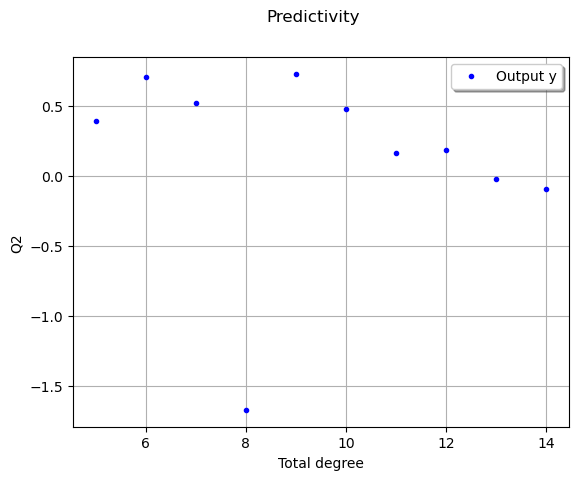

In [12]:
import openturns.viewer as viewer
from matplotlib import pylab as plt
graph = ot.Graph("Predictivity", "Total degree", "Q2", True)
cloud = ot.Cloud([[d] for d in degrees], q2[:, 0])
cloud.setLegend("Output y")
cloud.setPointStyle("bullet")
graph.add(cloud)
graph.setLegendPosition("topright")
view = viewer.View(graph)
plt.show()

# **Model 2:** Since the input distribution is known in our particular case, we can create the multivariate basis from the distribution. We also impose the degree in order to have the same as model1.


In [13]:
#complete metamodel  giving  the polynomial basis
multivariateBasis = ot.OrthogonalProductPolynomialFactory(distributionList)
totalDegree = 10
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
chaosalgo_2 = ot.FunctionalChaosAlgorithm(inputSample, outputSample, distribution, adaptiveStrategy)
chaosalgo_2.run()
results_2 = chaosalgo_2.getResult()
print('Model 2 - Basis size = ',len(np.array(results_2.getCoefficients())))

metamodel_2 = results_2.getMetaModel()

Model 2 - Basis size =  286


In [14]:
print('P number of coefficients = ',P)
print(results_2.getComposedMetaModel())

P number of coefficients =  286
0.930634 + 0.39274 * (1.73205 * x0) - 0.0143663 * (1.73205 * x1) + 0.15474 * (1.73205 * x2) - 0.181339 * (-1.11803 + 3.3541 * x0^2) + 0.00909046 * ((1.73205 * x0) * (1.73205 * x1)) + 0.0460232 * ((1.73205 * x0) * (1.73205 * x2)) - 0.292778 * (-1.11803 + 3.3541 * x1^2) + 0.00229009 * ((1.73205 * x1) * (1.73205 * x2)) - 0.227623 * (-1.11803 + 3.3541 * x2^2) - 0.202101 * (-3.96863 * x0 + 6.61438 * x0^3) + 0.106425 * ((-1.11803 + 3.3541 * x0^2) * (1.73205 * x1)) - 0.0209511 * ((-1.11803 + 3.3541 * x0^2) * (1.73205 * x2)) - 0.176803 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x1^2)) + 0.0833174 * ((1.73205 * x0) * (1.73205 * x1) * (1.73205 * x2)) + 0.119887 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x2^2)) - 0.0476801 * (-3.96863 * x1 + 6.61438 * x1^3) - 0.120855 * ((-1.11803 + 3.3541 * x1^2) * (1.73205 * x2)) + 0.157218 * ((1.73205 * x1) * (-1.11803 + 3.3541 * x2^2)) + 0.183701 * (-3.96863 * x2 + 6.61438 * x2^3) + 0.130233 * (1.125 - 11.25 * x0^2 + 13.125 * x0^4)

In [15]:
print(results_2)

meta model=(0.930634 + 0.39274 * (1.73205 * x0) - 0.0143663 * (1.73205 * x1) + 0.15474 * (1.73205 * x2) - 0.181339 * (-1.11803 + 3.3541 * x0^2) + 0.00909046 * ((1.73205 * x0) * (1.73205 * x1)) + 0.0460232 * ((1.73205 * x0) * (1.73205 * x2)) - 0.292778 * (-1.11803 + 3.3541 * x1^2) + 0.00229009 * ((1.73205 * x1) * (1.73205 * x2)) - 0.227623 * (-1.11803 + 3.3541 * x2^2) - 0.202101 * (-3.96863 * x0 + 6.61438 * x0^3) + 0.106425 * ((-1.11803 + 3.3541 * x0^2) * (1.73205 * x1)) - 0.0209511 * ((-1.11803 + 3.3541 * x0^2) * (1.73205 * x2)) - 0.176803 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x1^2)) + 0.0833174 * ((1.73205 * x0) * (1.73205 * x1) * (1.73205 * x2)) + 0.119887 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x2^2)) - 0.0476801 * (-3.96863 * x1 + 6.61438 * x1^3) - 0.120855 * ((-1.11803 + 3.3541 * x1^2) * (1.73205 * x2)) + 0.157218 * ((1.73205 * x1) * (-1.11803 + 3.3541 * x2^2)) + 0.183701 * (-3.96863 * x2 + 6.61438 * x2^3) + 0.130233 * (1.125 - 11.25 * x0^2 + 13.125 * x0^4) + 0.00709883 * ((-3

# **Model 3:** We can also compute a sparse basis by penalyzed least square using LAR.

In [16]:
#sparse metamodel using a sparse polynomial basis
multivariateBasis = ot.OrthogonalProductPolynomialFactory(distributionList)
totalDegree = 10
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
basisSequenceFactory = ot.LARS()
fittingAlgorithm = ot.CorrectedLeaveOneOut()
approximationAlgorithm = ot.LeastSquaresMetaModelSelectionFactory(
    basisSequenceFactory, fittingAlgorithm)
evaluationCoeffStrategy = ot.LeastSquaresStrategy(
    ot.MonteCarloExperiment(N), approximationAlgorithm)
chaosalgo_3 = ot.FunctionalChaosAlgorithm(
    inputSample, outputSample, distribution, adaptiveStrategy, evaluationCoeffStrategy)
chaosalgo_3.run()
results_3 = chaosalgo_3.getResult()
print('Model 3 - Basis size = ',len(np.array(results_3.getCoefficients())))

metamodel_3 = results_3.getMetaModel()

Model 3 - Basis size =  28


In [17]:
print(results_3.getComposedMetaModel())

3.52114 + 1.3903 * (1.73205 * x0) - 0.580135 * (-1.11803 + 3.3541 * x1^2) - 1.5146 * (-3.96863 * x0 + 6.61438 * x0^3) + 0.888028 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x2^2)) - 0.0635202 * ((-1.11803 + 3.3541 * x0^2) * (1.73205 * x1) * (1.73205 * x2)) - 0.0368425 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x1^2) * (1.73205 * x2)) - 1.85701 * (1.125 - 11.25 * x1^2 + 13.125 * x1^4) - 0.058676 * (1.125 - 11.25 * x2^2 + 13.125 * x2^4) - 1.38552 * ((-3.96863 * x0 + 6.61438 * x0^3) * (-1.11803 + 3.3541 * x2^2)) - 0.0531657 * ((1.73205 * x1) * (1.125 - 11.25 * x2^2 + 13.125 * x2^4)) + 1.34373 * (-1.12673 + 23.6614 * x1^2 - 70.9843 * x1^4 + 52.0551 * x1^6) - 0.471064 * ((-3.96863 * x0 + 6.61438 * x0^3) * (1.125 - 11.25 * x2^2 + 13.125 * x2^4)) - 0.017874 * ((-1.11803 + 3.3541 * x0^2) * (-3.96863 * x1 + 6.61438 * x1^3) * (-1.11803 + 3.3541 * x2^2)) - 0.150914 * ((1.73205 * x0) * (-1.12673 + 23.6614 * x2^2 - 70.9843 * x2^4 + 52.0551 * x2^6)) - 0.0265977 * (-8.47215 * x1 + 76.2494 * x1^3 - 167.749

In [18]:
print(results_3)

meta model=(3.52114 + 1.3903 * (1.73205 * x0) - 0.580135 * (-1.11803 + 3.3541 * x1^2) - 1.5146 * (-3.96863 * x0 + 6.61438 * x0^3) + 0.888028 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x2^2)) - 0.0635202 * ((-1.11803 + 3.3541 * x0^2) * (1.73205 * x1) * (1.73205 * x2)) - 0.0368425 * ((1.73205 * x0) * (-1.11803 + 3.3541 * x1^2) * (1.73205 * x2)) - 1.85701 * (1.125 - 11.25 * x1^2 + 13.125 * x1^4) - 0.058676 * (1.125 - 11.25 * x2^2 + 13.125 * x2^4) - 1.38552 * ((-3.96863 * x0 + 6.61438 * x0^3) * (-1.11803 + 3.3541 * x2^2)) - 0.0531657 * ((1.73205 * x1) * (1.125 - 11.25 * x2^2 + 13.125 * x2^4)) + 1.34373 * (-1.12673 + 23.6614 * x1^2 - 70.9843 * x1^4 + 52.0551 * x1^6) - 0.471064 * ((-3.96863 * x0 + 6.61438 * x0^3) * (1.125 - 11.25 * x2^2 + 13.125 * x2^4)) - 0.017874 * ((-1.11803 + 3.3541 * x0^2) * (-3.96863 * x1 + 6.61438 * x1^3) * (-1.11803 + 3.3541 * x2^2)) - 0.150914 * ((1.73205 * x0) * (-1.12673 + 23.6614 * x2^2 - 70.9843 * x2^4 + 52.0551 * x2^6)) - 0.0265977 * (-8.47215 * x1 + 76.2494 * x1

## PCE metamodel validation

Comparison of the 3 created metamodels using a  validation set to compute the predictive error: the lowest is the error, the closest to 1 is the predictive factor $Q_2$

In [19]:

val_1 = ot.MetaModelValidation(inputTest, outputTest, metamodel_1)
val_2 = ot.MetaModelValidation(inputTest, outputTest, metamodel_2)
val_3 = ot.MetaModelValidation(inputTest, outputTest, metamodel_3)
Q2_1 = val_1.computePredictivityFactor()
Q2_2 = val_2.computePredictivityFactor()
Q2_3 = val_3.computePredictivityFactor()
print('model 1', Q2_1)
print('model 2', Q2_2)
print('model 3', Q2_3)

model 1 [0.473659]
model 2 [-0.333235]
model 3 [0.953497]


# Computation of the sensitivity indices

In [20]:
SI_1 = ot.FunctionalChaosSobolIndices(results_1)
SI_2 = ot.FunctionalChaosSobolIndices(results_2)
SI_3 = ot.FunctionalChaosSobolIndices(results_3)
print('Indices with model 1')
print( SI_1)
print ('######################')
print('Indices with model 2')
print( SI_2)
print ('######################')
print('Indices with model 3')
print(SI_3)

Indices with model 1
 input dimension: 3
 output dimension: 1
 basis size: 68
 mean: [2.72306]
 std-dev: [3.38787]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
     26 | [0,6,0]                       | 0.174043
     14 | [0,4,0]                       | 0.161777
      1 | [1,0,0]                       | 0.110577
      7 | [3,0,0]                       | 0.0745795
      6 | [0,0,2]                       | 0.0619743
     54 | [3,0,2]                       | 0.0429243
     35 | [1,0,3]                       | 0.0407424
      9 | [0,0,3]                       | 0.0359444
     41 | [0,8,0]                       | 0.0315132
     23 | [1,0,2]                       | 0.0261724
     49 | [0,1,4]                       | 0.0184849
     21 | [1,2,0]                       | 0.0165855
     40 | [8,0,0]                       | 0.0156631
     52 | [0,0,9]            

In [21]:
## To draw Sobol  indices

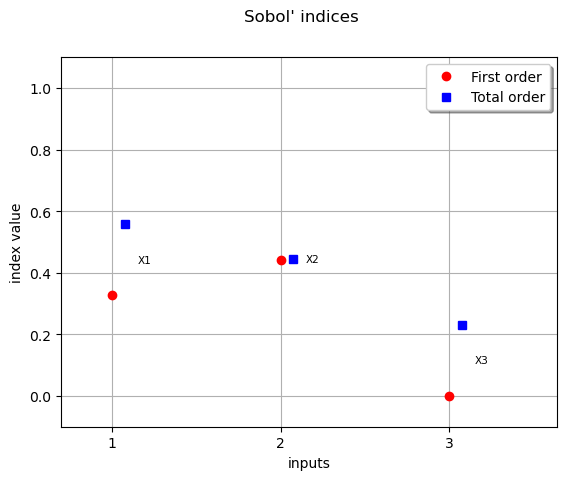

In [22]:

import openturns.viewer as viewer
from matplotlib import pylab as plt

first_order = [SI_3 .getSobolIndex(i) for i in range(inputDimension)]
total_order = [SI_3 .getSobolTotalIndex(
    i) for i in range(inputDimension)]
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(
    input_names, first_order, total_order)
view = viewer.View(graph)

We saw that total order indices are close to first order, so the higher order indices must be all quite close to 0

In [23]:
for i in range(inputDimension):
    for j in range(i):
        print(input_names[i] + ' & ' + input_names[j], ":",
              SI_3.getSobolIndex([i, j]))

plt.show()

X2 & X1 : 6.543836503448736e-05
X3 & X1 : 0.22847312237920794
X3 & X2 : 0.0006235637940279227


# Reference results

Comparisons of the computed Sobol indices with the reference ones (available for the Ishigami function)

In [24]:
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.'''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

a = 7.
b = 0.1
exact = ishigamiSA(a,b)
print('Reference indices')
exact

Reference indices


{'expectation': 3.5,
 'variance': 13.844587940719254,
 'S1': 0.31390519114781146,
 'S2': 0.4424111447900409,
 'S3': 0,
 'S12': 0,
 'S23': 0,
 'S13': 0.2436836640621477,
 'S123': 0,
 'ST1': 0.5575888552099592,
 'ST2': 0.4424111447900409,
 'ST3': 0.2436836640621477}

# 2. Bootstrap technique to compute error
## 2.1 Repetition
In order to estimate the coefficient of variation of the PCE estimator of the Sobol indices, some repetitions can be done.

In [25]:
inputDim = 3
repet = 700
input_names = ['x1', 'x2','x3']

#database size
N = 50

#Initialization
L_First_Order = []
L_Total_Index = []


In [26]:
#to choose randomly  the training and validation  set for the bootstrap
for j in range(repet):

    inputSample = distribution.getSample(N)
    outputSample = g(inputSample)
    basisSequenceFactory = ot.LARS()
    fittingAlgorithm = ot.CorrectedLeaveOneOut()
    approximationAlgorithm = ot.LeastSquaresMetaModelSelectionFactory(
    basisSequenceFactory, fittingAlgorithm)
    evaluationCoeffStrategy = ot.LeastSquaresStrategy(
    ot.MonteCarloExperiment(N), approximationAlgorithm)
    chaosalgo_3 = ot.FunctionalChaosAlgorithm(
    inputSample, outputSample, distribution, adaptiveStrategy, evaluationCoeffStrategy)
    chaosalgo_3.run()
    results_3 = chaosalgo_3.getResult()
    SI_3 = ot.FunctionalChaosSobolIndices(results_3)

    first_order = list(map(lambda i: SI_3.getSobolIndex(i), range(inputDim)))
    total_index = list(map(lambda i: SI_3.getSobolTotalIndex(i), range(inputDim)))

    L_First_Order.append(first_order)
    L_Total_Index.append(total_index)



In [27]:
#######post process
L_First_Order = np.array(L_First_Order)
L_Total_Index = np.array(L_Total_Index)

#print('Sensitivity analysis with sparse PCE of degree'+str(degree)+'\n')
#print('training sample of size = '+str(size_data-size_validation)+'\n')
#print('validation sample of size = '+str(size_validation)+'\n')
j=0
mean = L_First_Order[j*repet:(j+1)*repet].mean(axis = 0)
std =  L_First_Order[j*repet:(j+1)*repet].std(axis = 0)
cv = std/mean
print("###########################\n")

print("Sobol index, first order (coefficient of variation \%)\n")
for i in range(inputDim):
        print(input_names[i]+' : '+str(mean[i])+' ('+str(cv[i]*100)+'\%) \n')
print("First order sum = "+str(np.array(mean).sum())+'\n')
mean = L_Total_Index[j*repet:(j+1)*repet].mean(axis = 0)
std =  L_Total_Index[j*repet:(j+1)*repet].std(axis = 0)
cv = std/mean
print("Total Sobol index (coefficient of variation \%):\n")
for i in range(inputDim):
        print(input_names[i]+' : '+str(mean[i])+' ('+str(cv[i]*100)+'\%) \n')
print("Total Sobol index sum = "+str(np.array(mean).sum())+"\n")


###########################

Sobol index, first order (coefficient of variation \%)

x1 : 0.24000410443003253 (78.03618813836542\%) 

x2 : 0.4521944456335664 (54.526537015030804\%) 

x3 : 0.01371524316575822 (405.7734400041672\%) 

First order sum = 0.7059137932293572

Total Sobol index (coefficient of variation \%):

x1 : 0.47543102252280633 (52.68429626036949\%) 

x2 : 0.5686157292041913 (43.89034428130053\%) 

x3 : 0.2913465599787195 (86.74987960621812\%) 

Total Sobol index sum = 1.3353933117057173



This approch allows to estimate the variance of our estimator but it is in practice very costly as the PCE has to be rebuild using a new design of experiments at each repetition (evaluation of the numerical model $repet\times N$). In order to reduce this cost one can estimate the variance using resampling approach known as bootstrap.

## 2.2 Fixed database only once and reused with different training and validation set (Bootstrap approach)

In [28]:

#database chosen only once
inputSample = distribution.getSample(N)
outputSample = g(inputSample)
X=np.array(inputSample)
Y=np.array(outputSample)


#Initialization
L_First_Order = []
L_Total_Index = []



#to choose randomly  the training set for the bootstrap
for j in range(repet):

    Ind_train = np.random.choice(N,N,replace=True)
    #to choose the training set associated
    X_train = X[Ind_train,:]
    Y_train = Y[Ind_train].reshape((N,1))


    basisSequenceFactory = ot.LARS()
    fittingAlgorithm = ot.CorrectedLeaveOneOut()
    approximationAlgorithm = ot.LeastSquaresMetaModelSelectionFactory(
    basisSequenceFactory, fittingAlgorithm)
    evaluationCoeffStrategy = ot.LeastSquaresStrategy(
    ot.MonteCarloExperiment(N), approximationAlgorithm)
    chaosalgo_3 = ot.FunctionalChaosAlgorithm(
    X_train, Y_train, distribution, adaptiveStrategy, evaluationCoeffStrategy)
    chaosalgo_3.run()

    #Get the result:
    results = chaosalgo_3.getResult()
    sensitivityAnalysis = ot.FunctionalChaosSobolIndices(results)
    responseSurface = results.getMetaModel()

    sensitivityAnalysis = ot.FunctionalChaosSobolIndices(results)
    first_order = list(map(lambda i: sensitivityAnalysis.getSobolIndex(i), range(inputDim)))
    total_index = list(map(lambda i: sensitivityAnalysis.getSobolTotalIndex(i), range(inputDim)))


    L_First_Order.append(first_order)
    L_Total_Index.append(total_index)




In [29]:
#######post process
L_First_Order = np.array(L_First_Order)
L_Total_Index = np.array(L_Total_Index)



j=0
mean = L_First_Order[j*repet:(j+1)*repet].mean(axis = 0)
std =  L_First_Order[j*repet:(j+1)*repet].std(axis = 0)
cv = std/mean
print("###########################\n")

print("Sobol index, first order (coefficient of variation \%)\n")
for i in range(inputDim):
        print(input_names[i]+' : '+str(mean[i])+' ('+str(cv[i]*100)+'\%) \n')
print("First order sum = "+str(np.array(mean).sum())+'\n')
mean = L_Total_Index[j*repet:(j+1)*repet].mean(axis = 0)
std =  L_Total_Index[j*repet:(j+1)*repet].std(axis = 0)
cv = std/mean
print("Total Sobol index (coefficient of variation \%):\n")
for i in range(inputDim):
        print(input_names[i]+' : '+str(mean[i])+' ('+str(cv[i]*100)+'\%) \n')
print("Total Sobol index sum = "+str(np.array(mean).sum())+"\n")



###########################

Sobol index, first order (coefficient of variation \%)

x1 : 0.08465995679004157 (183.24129419939416\%) 

x2 : 0.2521807308693754 (114.93239166285696\%) 

x3 : 0.03302221562579012 (393.58897388292615\%) 

First order sum = 0.3698629032852071

Total Sobol index (coefficient of variation \%):

x1 : 0.43169655572691984 (83.3880711684535\%) 

x2 : 0.7339247126161245 (45.91694160257273\%) 

x3 : 0.5649197781513554 (68.07831097913972\%) 

Total Sobol index sum = 1.7305410464943995



It can be seen that bootstrap approach offers a correct approximation of the variance of the PCE estimator of the Sobol indices with a design of experiments of size only $N$

## Try to do the same test and increase the value of N in order to decrease the coefficient of variation
With $N= 500$ the error will decrease.